In [1]:
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
sys.path.append(parent_dir)
import parmed as pmd
import torch
import numpy as np
from system.topology import Topology
from forces.twobody import MixtureLJ, Harmonic_Bond, MixtureCoulomb
from forces.threebody import Harmonic_Angle
from forces.fourbody import Dihedral
import system.units as units
import system.box as box
import system.system as sys
from integrators.NVE import NVE
from integrators.NVT import NVT
import matplotlib.pyplot as plt
import math
from tqdm import trange
from utils import *
dtype=torch.float32
device="cuda"


╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

In [2]:
top, node_features, mass, energy_dict = build_top_and_features("alanine-dipeptide.prmtop")
B = 2*4096
pos = torch.tensor(pmd.load_file("alanine-dipeptide.pdb").coordinates,dtype=dtype,device=device).unsqueeze(0).expand(B, -1, -1).contiguous()
atomic_numbers = [a.atomic_number for a in pmd.load_file("alanine-dipeptide.pdb").atoms]
b = box.Box([1000,1000,1000],["s","s","s"])
u = units.UnitSystem.akma()
mom = 0.5*torch.randn_like(pos)

S = sys.System(pos, mom, mass, top, b, energy_dict, u, node_features)
S.potential_energy()
S.compile_force_fn()
S.pos = S.pos - (S.mass.unsqueeze(-1) * S.pos).sum(dim=1, keepdim=True) / S.mass.sum(dim=1, keepdim=True).unsqueeze(-1)

integrator = NVT(0.04, 10, 300)
print(integrator)

NVT(dt=0.04, gamma=10, T=300)


In [3]:
steps = 5_000
skip = 200
positions = torch.empty((int(steps / skip), B, 22, 3), device=device)

with torch.no_grad():
    for i in trange(steps, desc="Running simulation"):
        if i % skip == 0:
            positions[int(i / skip)] = S.pos
        integrator.step(S)
        S.reset_cache()
        S.pos = S.pos - (S.mass.unsqueeze(-1) * S.pos).sum(dim=1, keepdim=True) / S.mass.sum(dim=1, keepdim=True).unsqueeze(-1)

Running simulation: 100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [01:34<00:00, 52.95it/s]


/tmp/ipykernel_24619/279597291.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(hist, origin='lower', extent=extent, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax,levels=50)


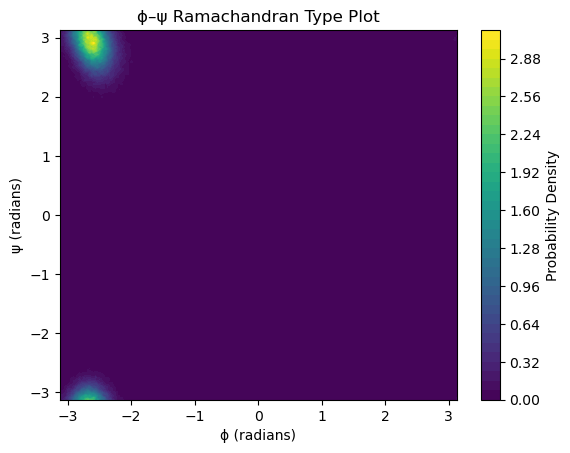

In [4]:
bins = 200
extent = [-math.pi, math.pi, -math.pi, math.pi]
range_ = [extent[:2], extent[2:]]
dihedrals = compute_dihedrals(positions, top.get_tensor(4, 'dihtype_6'))  # (T, M, 2)
data = dihedrals.reshape(-1, 2).cpu().numpy()  # (T × M, 2)
hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=bins, range=range_, density=True)
vmin, vmax = 0, hist.max()
plt.contourf(hist, origin='lower', extent=extent, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax,levels=50)
plt.xlabel("ϕ (radians)")
plt.ylabel("ψ (radians)")
plt.title("ϕ–ψ Ramachandran Type Plot")
plt.colorbar(label="Probability Density")
plt.show()

save_xyz(positions[:,:1],atomic_numbers)